# Income Classification Using XGBoost in R

In [2]:
library("readr")
library("dplyr")
library("xgboost")
library("ggplot2")
library("repr")
library("ROCR")
library("zeallot")
library('functClust')
library('e1071')
library('caret')

**Read Model Data**

In [3]:
X_train<-as.matrix(select(read_csv("./Model_Data/XGBOOST_X_train.csv",col_types = cols()), -X1))
X_test<-as.matrix(select(read_csv("./Model_Data/XGBOOST_X_test.csv",col_types = cols()), -X1))
y_train<-as.matrix(select(read_csv("./Model_Data/XGBOOST_y_train.csv",col_types = cols()), -X1))
y_test<-as.matrix(select(read_csv("./Model_Data/XGBOOST_y_test.csv",col_types = cols()), -X1)) 

Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”


**Set Model Parameters**

In [4]:
parameters <- list(max_depth = 6, eta = 0.3, 
                   objective ='binary:logistic', 
                   min_child_weight = 5)

**Train Model**

In [5]:
n_first <- floor(dim(X_train)[1] * .8)
dtrain <- xgb.DMatrix(X_train[1:n_first,], label = y_train[1:n_first,])
dvalid <- xgb.DMatrix(X_train[(n_first+1):dim(X_train)[1],], label = y_train[(n_first+1):dim(y_train)[1],])
dtest  <- xgb.DMatrix(X_test, label = y_test)

In [6]:
set.seed(4241)
model<- xgb.train(params = parameters,
          data = dtrain,
          nthread = 1,
          watchlist = list(train_set = dtrain, valid_set = dvalid),
          eval_metric = 'auc',
          verbose = 1,
          nrounds = 250,
          early_stopping_rounds = 20)

[1]	train_set-auc:0.883690	valid_set-auc:0.885640 
Multiple eval metrics are present. Will use valid_set_auc for early stopping.
Will train until valid_set_auc hasn't improved in 20 rounds.

[2]	train_set-auc:0.894657	valid_set-auc:0.895219 
[3]	train_set-auc:0.901799	valid_set-auc:0.902087 
[4]	train_set-auc:0.904936	valid_set-auc:0.905649 
[5]	train_set-auc:0.909204	valid_set-auc:0.909390 
[6]	train_set-auc:0.910977	valid_set-auc:0.910844 
[7]	train_set-auc:0.913084	valid_set-auc:0.913164 
[8]	train_set-auc:0.914969	valid_set-auc:0.914888 
[9]	train_set-auc:0.916652	valid_set-auc:0.915815 
[10]	train_set-auc:0.918418	valid_set-auc:0.918012 
[11]	train_set-auc:0.919982	valid_set-auc:0.918996 
[12]	train_set-auc:0.921681	valid_set-auc:0.919795 
[13]	train_set-auc:0.922650	valid_set-auc:0.920320 
[14]	train_set-auc:0.923389	valid_set-auc:0.920866 
[15]	train_set-auc:0.924574	valid_set-auc:0.921583 
[16]	train_set-auc:0.925518	valid_set-auc:0.922045 
[17]	train_set-auc:0.926655	valid_set

In [7]:
#xgb.save(model, './Model_Data/XGBOOST_R.model')

**Plot Feature Importance**

In [8]:
plot_feature_importance <- function(model){

    feature_importance <- as.data.frame(xgb.importance(model = model)[, c("Feature","Gain")])
    colnames(feature_importance) <- c("feature", "importance")
    best_features <- head(feature_importance, 10)

    plt <- ggplot(best_features, aes(x = reorder(feature, importance), y = importance , fill = -importance)) +
      geom_col() +
      coord_flip() +
      scale_color_gradient() +
      theme(axis.title.x = element_text(size = 16),
            axis.text.y = element_text(size = 14),
            axis.title.y = element_text(size = 16))
    
    options(repr.plot.width=10, repr.plot.height=6)
    
    return(list(plt,best_features))
    }

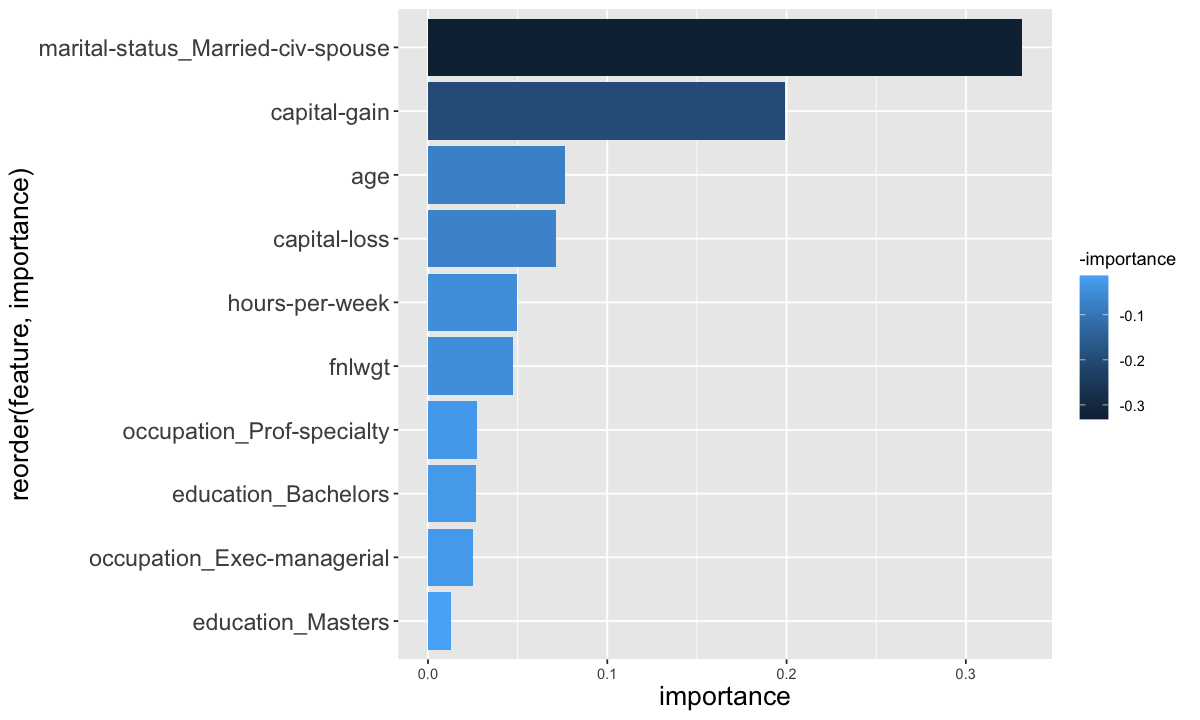

In [9]:
plot_feature_importance(model)[[1]]

**Define Function for Plotting the Roc Curve**

In [10]:
plot_roc_curve <- function(X, y, model, which_set){

    y_pred <- predict(model, X, ntreelimit = model$best_iteration)
    model.pred <- prediction(y_pred, y)

    perf_xgb <- performance(model.pred, "tpr", "fpr")
    c(tpr,fpr,threshold) %<-% list(perf_xgb@y.values[[1]],perf_xgb@x.values[[1]], perf_xgb@alpha.values[[1]])
    auc <- performance(model.pred, measure = "auc")@y.values[[1]]
    
    plt <-plot(perf_xgb, col = "orange", 
                lwd = 5, cex.lab = 1.5, cex.main=1.5, main = sprintf("ROC Curve for %s Set", which_set))
    lines(seq(0,1,0.05),seq(0,1,0.05),lty=2,lwd=2,col="darkblue")
    auc_rounded <- signif(as.numeric(auc),3)
    legend("bottomright", c(sprintf("ROC Curve (area = %s)",auc_rounded))
           , pch=c(19,17), col=c("orange"), cex=1.2)
    
    return(list(y_pred, fpr, tpr, threshold))
    }

**Apply the Plot on Validation Set and Get Predicted Probabilities, 
Get Each Threshold and Related True Positive and False positive Rates**


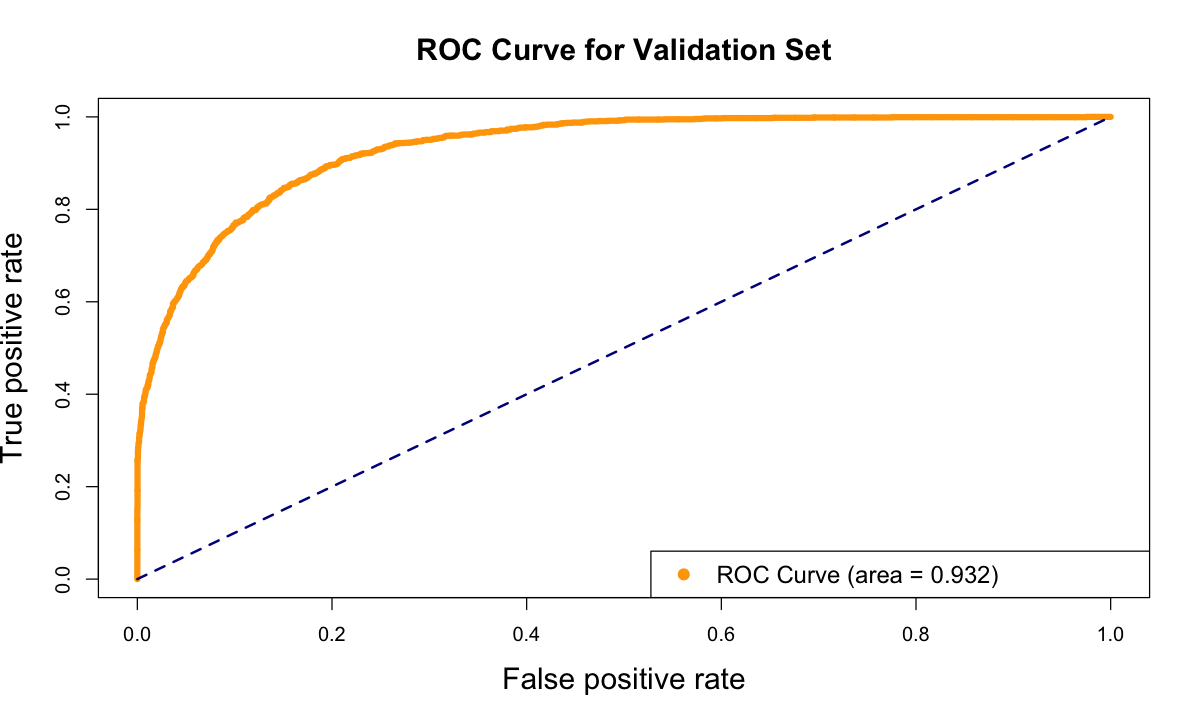

In [11]:
y_valid <- y_train[(n_first+1):dim(y_train)[1],]
c(y_pred_valid, fpr_valid, tpr_valid, threshold_valid ) %<-% 
             plot_roc_curve(dvalid, y_valid, model, which_set = "Validation")

**Define the Function for Getting Predicted Classes 
as well as Getting the Optimal Threshold obtained from Roc Curve**

In [12]:
prediction_with_optimal_auc <- function(y_pred, tpr, fpr, threshold){
    
    optimal_idx = which.max(tpr - fpr) #2275
    optimal_threshold = threshold[optimal_idx]
    y_pred <- ifelse(y_pred >= optimal_threshold, 1, 0)
    
    return(list(y_pred, signif(optimal_threshold,2)))
    }

In [13]:
c(y_pred_valid, optimal_treshold_valid) %<-% 
                                prediction_with_optimal_auc(y_pred_valid, tpr_valid, fpr_valid, threshold_valid)

In [14]:
optimal_treshold_valid

[1] 0.21

***Plot Confusion Matrix***

In [15]:
plot_confusion_matrix <- function(y_pred,y, normalize = FALSE){
    
    cm <- confusionMatrix(as.factor(y_pred), as.factor(y))$table
    cm <- as.data.frame(cm)
    colnames(cm) <- c("pred", "actual", "freq")
    
    cm_actual0_freqsum <- cm %>%
                   filter(actual == 0) %>%
                   summarize(freq = sum(freq))
    
    cm_actual1_freqsum <- cm %>%
               filter(actual == 1) %>%
                   summarize(freq = sum(freq))
    
    c(cm_actual0_freqsum, cm_actual1_freqsum) %<-% list(cm_actual0_freqsum[[1]], cm_actual1_freqsum[[1]])
    
    cm <- cm %>%
       mutate(prop = case_when(actual == 0  ~ freq / cm_actual0_freqsum*100,
                        actual == 1  ~ freq / cm_actual1_freqsum*100), 
              pred = case_when(pred == 0  ~ "<=50K",
                        pred == 1  ~ ">50K"),
              actual = case_when(actual == 0  ~ "<=50K",
                        actual == 1  ~ ">50K"))

    if (normalize){
        plt <- ggplot(data = cm, aes(x = pred , y = actual, fill = prop)) +
                geom_tile() +
                geom_text(aes(label = paste("",round(prop),"%")), color = 'white', size = 8)
    }else{
        plt <- ggplot(data = cm, aes(x = pred , y =  actual, fill = freq)) +
               geom_tile() +
               geom_text(aes(label = paste("",freq)), color = 'white', size = 8)
    }
    
    plt +
      labs(x = "Predicted label", y = "True label", title = "Confusion matrix") +
      theme(axis.title.x = element_text(size = 16),
                axis.text.y = element_text(size = 14),
                axis.text.x = element_text(size = 14),
                axis.title.y = element_text(size = 16),
                plot.title = element_text(hjust = 0.5, size =18)) +
      scale_y_discrete(limits = unique(rev(cm$pred)))
    }

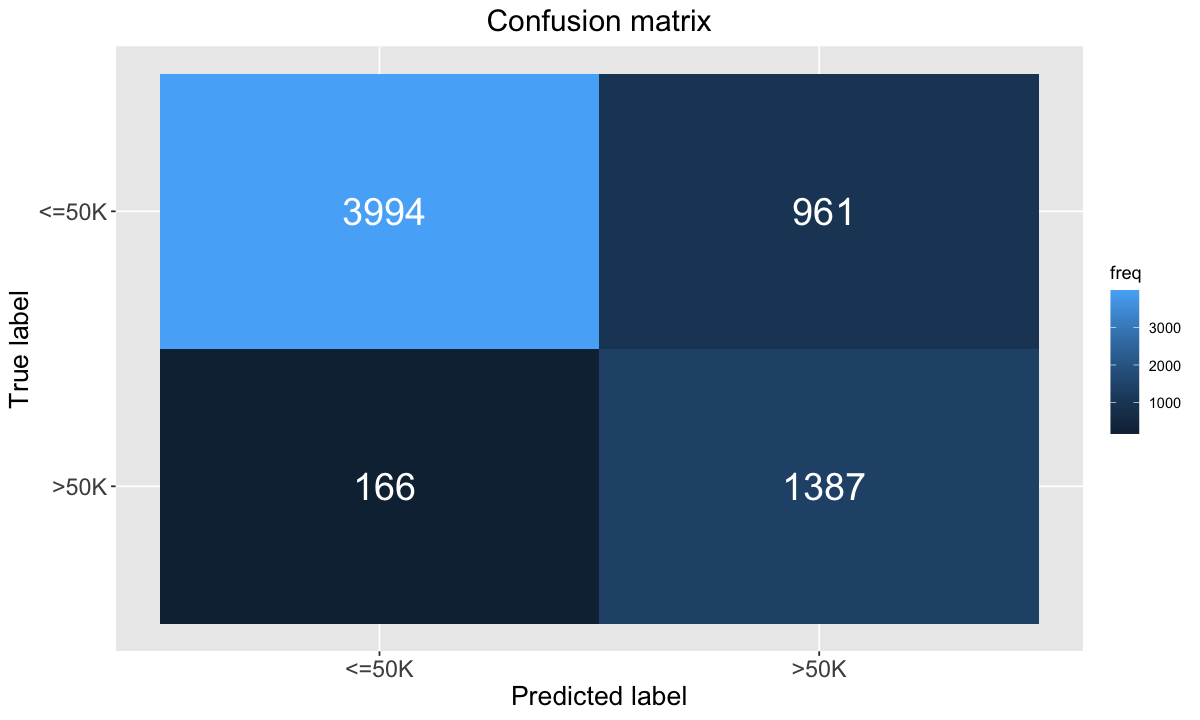

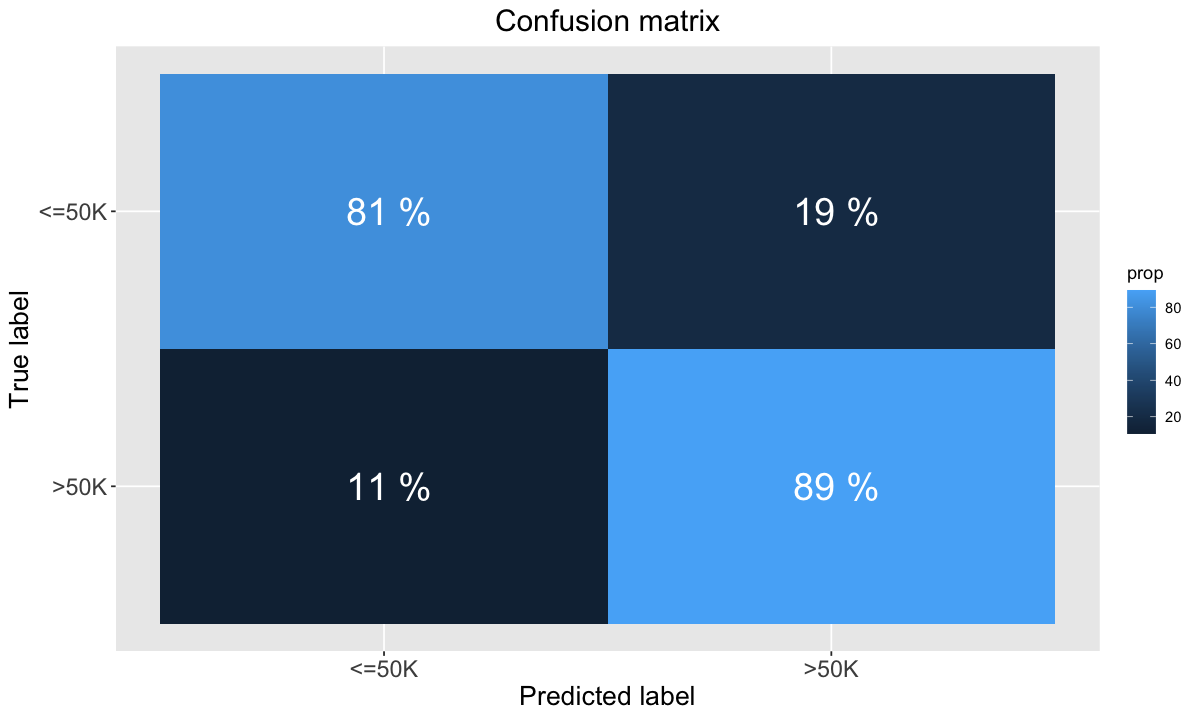

In [16]:
plot_confusion_matrix(y_pred_valid, y_valid)
plot_confusion_matrix(y_pred_valid, y_valid, TRUE)

**Model Metrics and Plots for the Test Set**

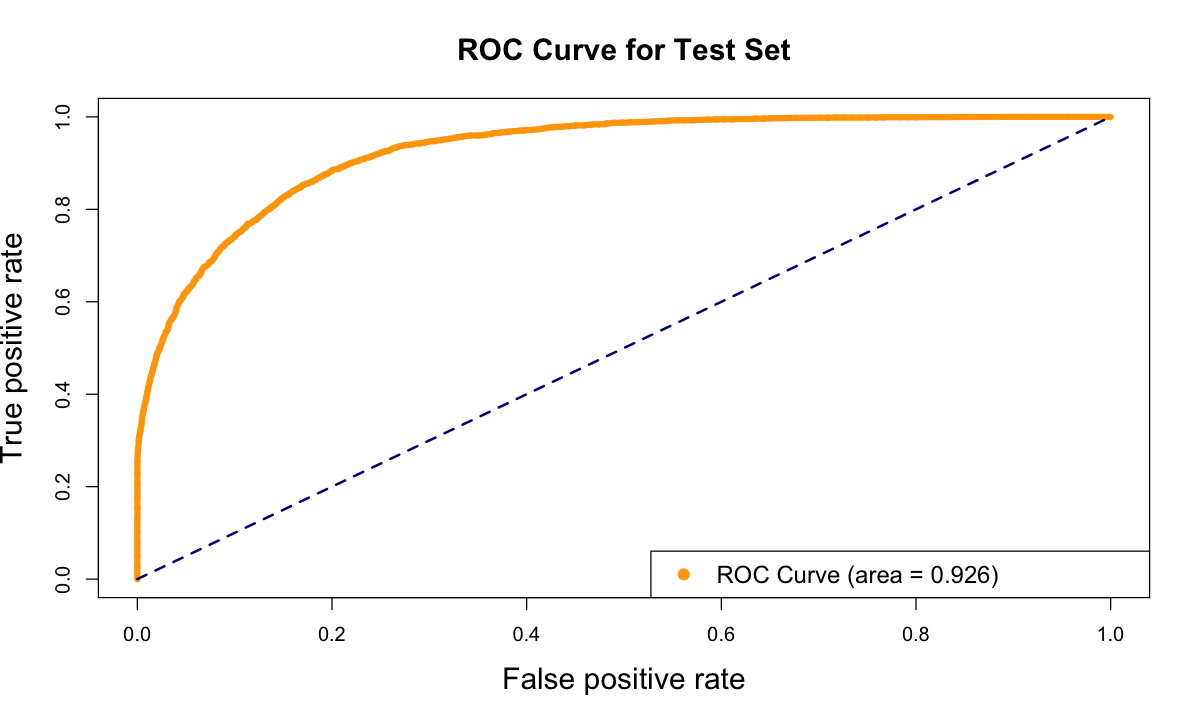

In [17]:
c(y_pred_test, fpr_test, tpr_test, threshold_test ) %<-% 
             plot_roc_curve(dtest, y_test, model, which_set = "Test")

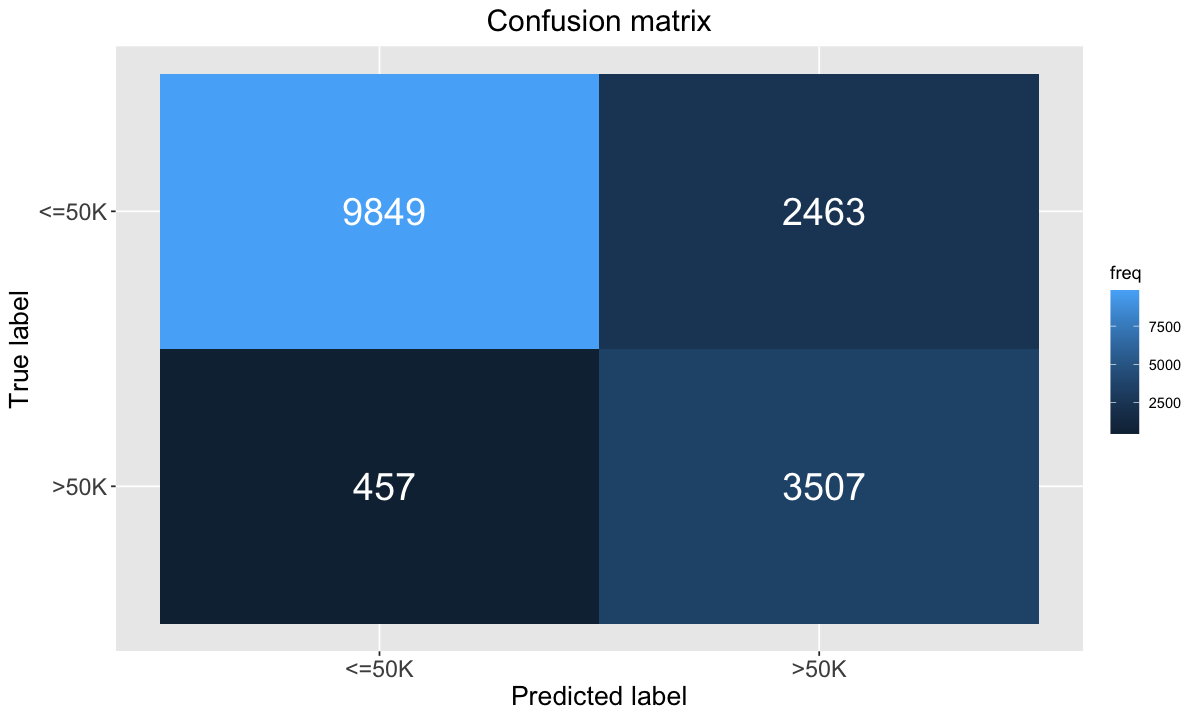

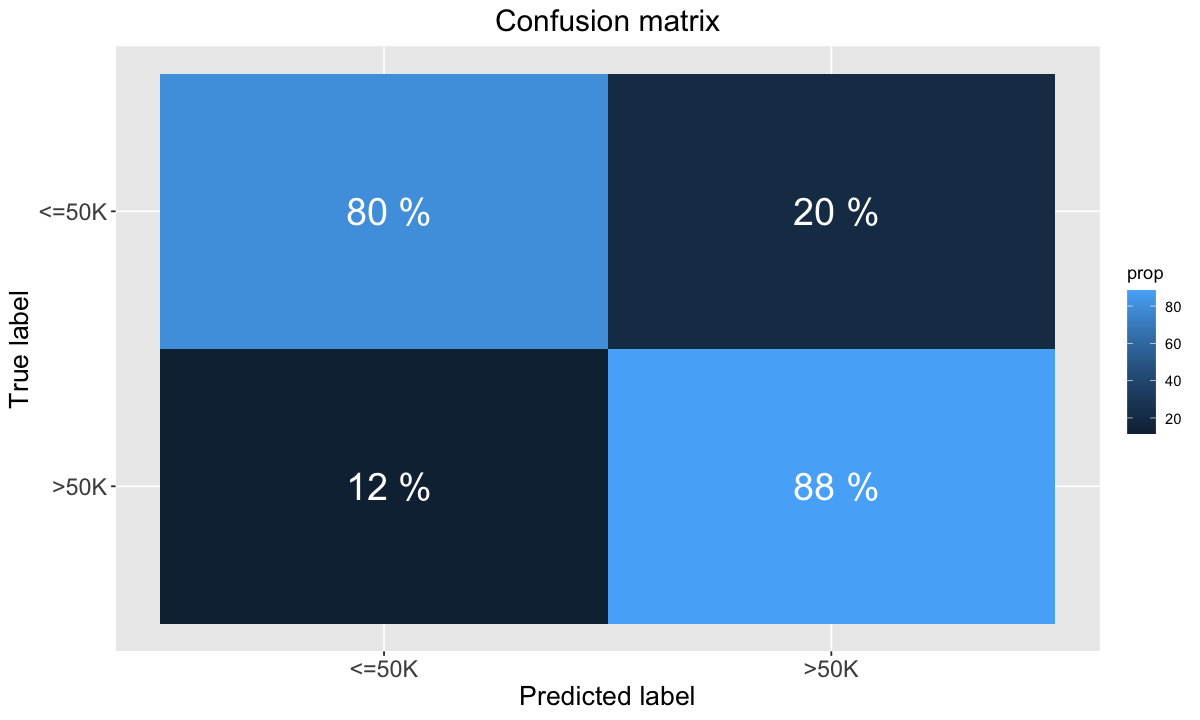

In [18]:
c(y_pred_test, optimal_treshold_test) %<-% 
                                prediction_with_optimal_auc(y_pred_test, tpr_test, fpr_test, threshold_test)

plot_confusion_matrix(y_pred_test, y_test)
plot_confusion_matrix(y_pred_test, y_test, TRUE)